In [1]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import pandas as pd


In [2]:
df = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/feed_into_pipeline_data_with_weeks.csv')
summaries = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/GlobalOriginalsWithSummary.csv')[['combined_title', 'summary']]
people_rankings = pd.read_csv('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/showsWithPrinicpalVotes.csv')[['combined_title', 'director_votes', 'writer_votes', 'actor_votes']]
df = df.merge(summaries, on='combined_title')
df = df.merge(people_rankings, on='combined_title')
# delete is_top_ten
del df['is_top10']
# make all current_weeks >= 1 to 1
df['cumulative_weeks_in_top_10'] = df['cumulative_weeks_in_top_10'].apply(lambda x: 1 if x >= 1 else 0)
# if language is not english, make it Non-English
df['language'] = df['language'].apply(lambda x: 'Non-English' if x != 'English' else x)
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]
movies = movies.set_index('tconst')
movies = movies.drop(['tconst', 'release_date', 'combined_title', 'lower_title', 'season', 'is_tv_show'], axis = 1, errors = 'ignore')

In [3]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

#movie_X_train, movie_X_test, movie_y_train, movie_y_test = train_test_split(movies.drop('is_top10', axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])
movie_X_train, movie_X_test, movie_y_train, movie_y_test = train_test_split(movies.drop('cumulative_weeks_in_top_10', axis=1), movies['cumulative_weeks_in_top_10'], test_size=0.2, random_state=42)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),

        #("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),
        #("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),
        #("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),
        #("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),
        ("onehot_l",OneHotEncoder(handle_unknown='ignore'), ['language']),

        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),
        #("bagofwords", CountVectorizer(stop_words='english', min_df=0.02), 'summary'),
        #("tfidf", TfidfVectorizer(stop_words='english', min_df=0.02), 'summary'),
        ("genres_count", CountVectorizer(min_df=0.05), 'genres'),
        #("sentence_transformer", embedder, 'summary'),
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_votes', 'actor_votes', 'writer_votes']),
    ],
    remainder='passthrough')

In [5]:
# Recreate pipeline using XGBoost

xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.1, 0.5],
        'xgb__n_estimators': [100, 200, 300]
    },
    scoring={"AUC": "roc_auc", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [6]:
# movie_X_train drop summart
xgb_gs.fit(movie_X_train.drop('summary', axis=1), movie_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_v',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['violence']),
                                                                        ('onehot_l',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                            

In [460]:
#feature_names = xgb_gs.best_estimator_.named_steps['xgb_transformer'].transformers_[4][1].get_feature_names_out()
#feature_names

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'mystery', 'romance', 'thriller'],
      dtype=object)

In [7]:
colsW = ['x0_movie', 'x0_short', 'x0_tvSpecial','x0_Mild', 'x0_Moderate', 'x0_None', 'x0_Severe','x0_English', 'x0_Non-English','x0_2020', 'x0_2021', 'x0_2022','action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'mystery', 'romance', 'thriller', 'director_votes','actor_votes','writer_votes','averageRating','numVotes','runtimeMinutes','release_date_quarter','release_date_month',"release_date_week"]

In [8]:
# get model performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#y_pred = xgb_gs.predict(movie_X_test.drop(columns=['summary']))
#print('Mean Squared Error:', mean_squared_error(movie_y_test, y_pred))
#print('Mean Absolute Error:', mean_absolute_error(movie_y_test, y_pred))
#print('R2 Score:', r2_score(movie_y_test, y_pred))

In [9]:
# baseline model
from sklearn.dummy import DummyRegressor
#dummy_regr = DummyRegressor(strategy="mean")
#dummy_regr.fit(movie_X_train.drop(columns=['summary']), movie_y_train)
#dummy_regr.predict(movie_X_test.drop(columns=['summary']))
#print('Mean Squared Error:', mean_squared_error(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))
# compare mse to model
#(r2_score(movie_y_test, y_pred) - r2_score(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))/abs(r2_score(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))
#(mean_squared_error(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))) - mean_squared_error(movie_y_test, y_pred))/abs(mean_squared_error(movie_y_test, dummy_regr.predict(movie_X_test.drop(columns=['summary']))))

In [12]:
xgb_gs.best_score_
#0.825311 no summary
#0.827196 with bow summary
#0.825758 with tfidf summary

0.9383254311825739

In [13]:
# test auc
from sklearn.metrics import roc_auc_score
y_pred = xgb_gs.predict_proba(movie_X_test.drop(columns=['summary']))[:,1]
roc_auc_score(movie_y_test, y_pred)

0.8843864468864469

In [14]:
# model accuracy
xgb_gs.score(movie_X_test.drop(columns=['summary']), movie_y_test)


0.8843864468864469

In [15]:
# model f1 score
from sklearn.metrics import f1_score
y_pred = xgb_gs.predict(movie_X_test.drop(columns=['summary']))
f1_score(movie_y_test, y_pred, average='weighted')

0.8906455862977601

In [30]:
# predict probabilities - test
y_pred = xgb_gs.best_estimator_.predict_proba(movie_X_test.drop(columns=['summary']))
y_pred = pd.DataFrame(y_pred, columns=['y_pred_0', 'y_pred_1'])
y_pred['title'] = movie_X_test.index
y_pred['actual'] = movie_y_test.to_numpy()
# delete movies that are not top 10
y_pred = y_pred[y_pred['actual']==0]
y_pred.sort_values(by='y_pred_1', ascending=False).head(20)


,y_pred_0,y_pred_1,title,actual
55,0.760260,0.239740,tt5748448,0
180,0.768403,0.231597,tt10962368,0
96,0.777964,0.222036,tt12141112,0
35,0.808344,0.191656,tt5498354,0
181,0.815322,0.184678,tt9731386,0
24,0.815355,0.184645,tt21340412,0
70,0.855721,0.144279,tt7392014,0
69,0.867780,0.132220,tt7846844,0
162,0.869343,0.130657,tt11100856,0
33,0.877642,0.122358,tt11199410,0


In [29]:
# predict probabilities - train
y_pred = xgb_gs.predict_proba(movie_X_train.drop(columns=['summary']))
y_pred = pd.DataFrame(y_pred, columns=['y_pred_0', 'y_pred_1'])
y_pred['title'] = movie_X_train.index
y_pred['actual'] = movie_y_train.to_numpy()
# delete movies that are not top 10
y_pred = y_pred[y_pred['actual']== 0]
y_pred.sort_values(by='y_pred_1', ascending=False).head(20)

,y_pred_0,y_pred_1,title,actual
626,0.036494,0.963506,tt6111574,0
587,0.064088,0.935912,tt15101956,0
726,0.098150,0.901850,tt11209212,0
74,0.109432,0.890568,tt15085784,0
481,0.162288,0.837712,tt1587420,0
566,0.168629,0.831371,tt9013182,0
364,0.184947,0.815053,tt7084386,0
580,0.198261,0.801739,tt6733874,0
108,0.235690,0.764310,tt14544192,0
150,0.244654,0.755346,tt10293406,0


In [22]:
import shap

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
model = xgb_gs.best_estimator_['xgb'].fit(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_train), movie_y_train)
modelTest = xgb_gs.best_estimator_['xgb'].fit(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_test), movie_y_test)



In [24]:
explainer = shap.Explainer(model, xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_train), feature_names=colsW , model_output='probability')
explainerTest = shap.Explainer(model, xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_test), feature_names=colsW , model_output='probability')



In [25]:
shap_values = explainer(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_train))
shap_valuesTest = explainer(xgb_gs.best_estimator_['xgb_transformer'].transform(movie_X_test))


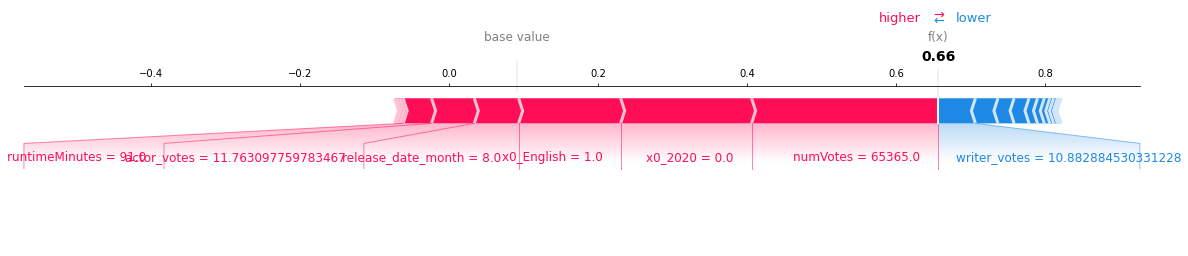

In [28]:
# force plot
shap.plots.force(shap_values[412], matplotlib=True)

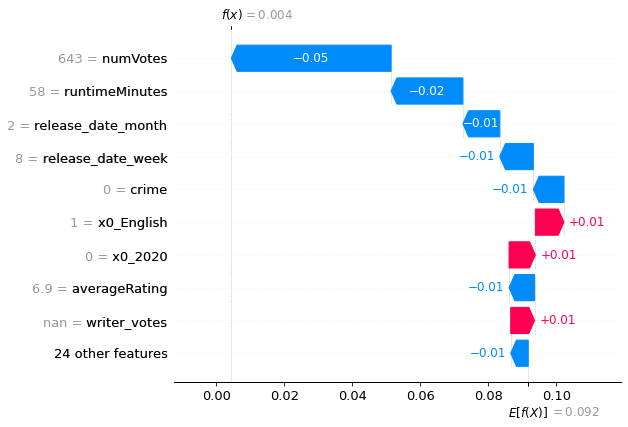

In [27]:
shap.plots.waterfall(shap_values[155])
# make y-axis font white